# Using image processing and scikitlearn linear models to model the Aral Sea's decline using topographical imagery

I've recently become interested in the Aral Sea due to my interest in ecological disasters and preservation in the face of climate change. As one of the world's premiere and most saddening examples of anthropogenic environmental discussion, the Aral Sea represents a large, multifaceted challenge to environmentalists and government authorities: with just one of these many challenges being assessing the actual level of water in the basin in the first place, given the remoteness of the Sea itself. I wanted to use my data science skills and some classwork I had done on image processing and classification to see if I could build a model capable of accurately predicting the changes in water volume based off an initial assessment based solely on easily-acquired satellite imagery, which ideally would reduce the costs needed for continual water level measurements.

In [501]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' 
import numpy as np

from datetime import datetime
from glob import glob
from skimage import io

from skimage.filters.rank import entropy 
from skimage.morphology import disk
from skimage.color import rgb2gray 

from skimage import img_as_ubyte, img_as_uint, img_as_float64 
from skimage.transform import rotate 
from PIL import Image

import scipy
#2

In [226]:

from skimage import img_as_ubyte, img_as_uint, img_as_float64

from skimage import data,exposure
from skimage.transform import rotate

# from sklearn.cluster import KMeans
import argparse

def plot_channel_intensities(image):
    # plot the distribution of intensities for each of the three bands in the
    # image.

    red = image[:,:,0]
    green = image[:,:,1]
    blue = image[:,:,2]

    mask = ( red + green + blue ) > 0

    fig, ax_hist = plt.subplots(1, 1, figsize=(6, 5))

    # histogram of each
    ax_hist.hist(red[mask].ravel(), bins=256, histtype='step', color='red')
    ax_hist.hist(green[mask].ravel(), bins=256, histtype='step', color='green')
    ax_hist.hist(blue[mask].ravel(), bins=256, histtype='step', color='blue')

    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))

    ax_hist.set_ylabel('Pixel Count')
    ax_hist.set_xlabel('Pixel intensity')

def rescale_intensities(image,flow,fhigh):
    red = image[:,:,0]
    green = image[:,:,1]
    blue = image[:,:,2]

    mask = ( red + green + blue ) > 0

    # Pick percentile overwhich to rescale intensities
    #flow = 2
    #fhigh = 98

    plow, phigh = np.percentile(red[mask], (flow, fhigh))
    ls_red_rs= exposure.rescale_intensity(red, in_range=(plow, phigh))

    plow, phigh = np.percentile(green[mask], (flow, fhigh))
    ls_green_rs= exposure.rescale_intensity(green, in_range=(plow, phigh))

    plow, phigh = np.percentile(blue[mask], (flow, fhigh))
    ls_blue_rs= exposure.rescale_intensity(blue, in_range=(plow, phigh))

    # Define empty image
    nx,ny = ls_red_rs.shape
    ls_rgb_stretched = np.zeros([nx,ny,3],dtype=np.float64)

    # set all 3 channels of the image
    ls_rgb_stretched[:,:,0] = ls_red_rs.astype(int)
    ls_rgb_stretched[:,:,1] = ls_green_rs.astype(int)
    ls_rgb_stretched[:,:,2] = ls_blue_rs.astype(int)

    return  ls_rgb_stretched.astype(int)


def bar_plot_with_colors(hist,colors,labels):

    # Matplotlib takes an RGB *fraction* as input for colors
    cm = [tuple(1.*np.array(c)/255.) for c in colors] # Matplotlib colormap takes a fraction

    plt.figure(figsize=(10, 3))
    plt.title('Fractional area of color clusters')
    plt.subplot(121)
    plt.bar(labels,hist,color=cm)
    
def quantize_color(im):
    """returns counts and palettes arrays"""
    imageRGB = Image.fromarray(img_as_ubyte(im))
    imageIndexed1 = imageRGB.quantize(colors=7, kmeans=1)
    rgbFromIndexed = imageIndexed1.convert("RGB")
    plt.imshow(rgbFromIndexed)
    plt.show()
    counts = []
    palette = []
    for c, p in rgbFromIndexed.getcolors():
        counts.append(c)
        palette.append(p)
    return counts, palette


To illustrate the magnitude of ecological change wrought in the Aral, here it is in 1984.

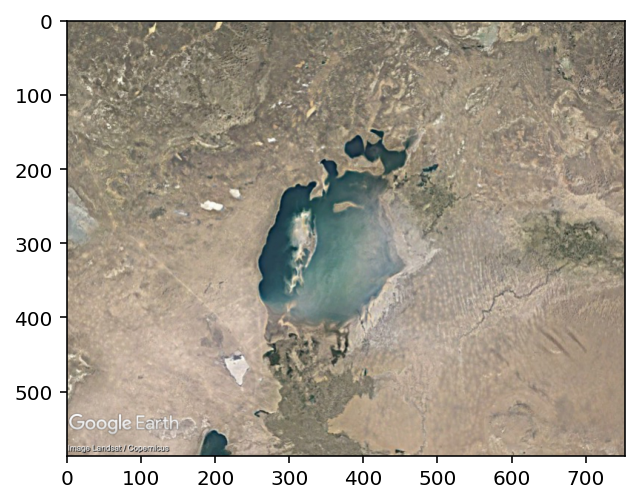

In [486]:
image = io.imread("AralPhotos/aral1984.jpg")
plt.imshow(image)

And in 2010:

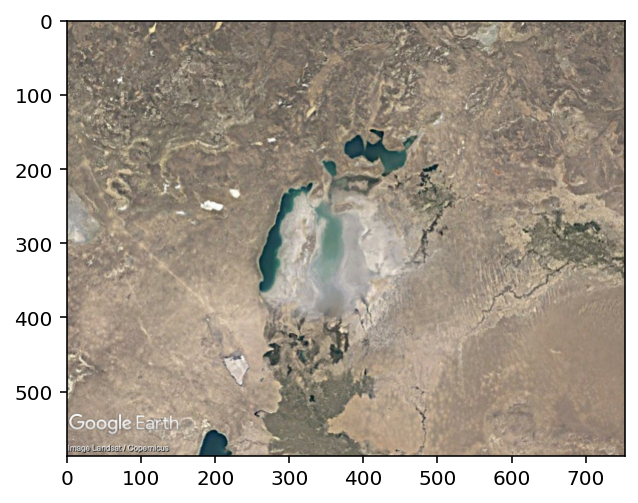

In [493]:
image = io.imread("AralPhotos/aral2010.jpg")
plt.imshow(image)


My challenge here is to take these detailed satellite photos and figure out a way of making them easy to analyze with the tools I have. Here I generate a false-color image that significantly homogenizes the terrain's colors, which is a quick-and-easy way of transforming my data to bin the pixels easier without having to run a clustering algorithm on multiple large images. I run the risk of over-homogenizing and losing clarity if my data starts grouping water pixels with ground pixels, but I took a calculated risk based on the fact that the colors are significantly different to each other.

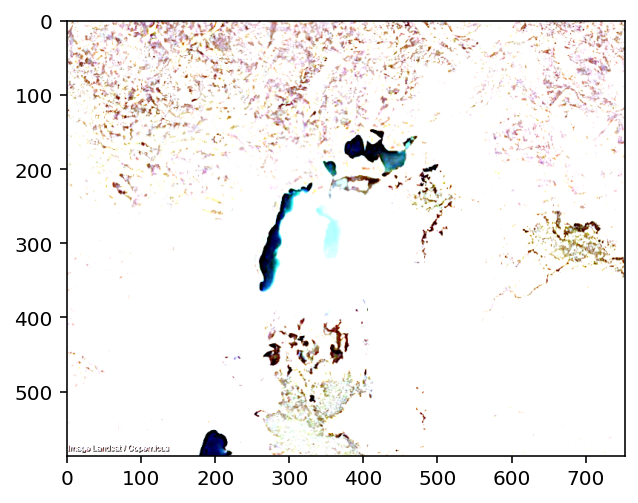

In [495]:
image = io.imread("AralPhotos/aral2010.jpg")
#image_new_dtype = img_as_float64(image)
#imageRGB = Image.fromarray(img_as_ubyte(image)) 

#can we do some false-color replacement here?
flow = 1
fhigh = 15
ls_rgb_rescale = rescale_intensities(image,flow,fhigh) 
#plot_channel_intensities(ls_rgb_rescale)
plt.imshow(ls_rgb_rescale)


Here I define an operation that uses color quantizing to show what the most common colors in the image are. I use this to bin pixels by color so I can sum the pixels reasonably fitting under 'blue', so I can compare the proportion of the image showing water across different years.

In [496]:
colors_arr = []

def generate_bar_plots(years_arr):
    for year in years_arr:
        
        flow = 1
        fhigh = 15

        filename = "AralPhotos/aral" + str(year) + ".jpg"
        image = io.imread(filename)
        image = rescale_intensities(image,flow,fhigh) 
        
        
        imageRGB = Image.fromarray(img_as_ubyte(image)) 
        imageIndexed = imageRGB.quantize(colors=7, kmeans=1)
        colors_arr.append(imageIndexed.getcolors()[1:])
        counts = []
        for val in imageIndexed.getcolors()[1:]:
            counts.append(val[0])
        palette = []

        for val in imageIndexed.convert("RGB").getcolors()[1:]:
            palette.append(val[1])

        labels = []
        for val in imageIndexed.getcolors()[1:]:
            labels.append(val[1])
            
        
        
        bar_plot_with_colors(counts,palette,labels)
        #return colors_arr
        #print(imageIndexed.getcolors()[1:])
        

<ipython-input-226-7027314c7557>:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10, 3))


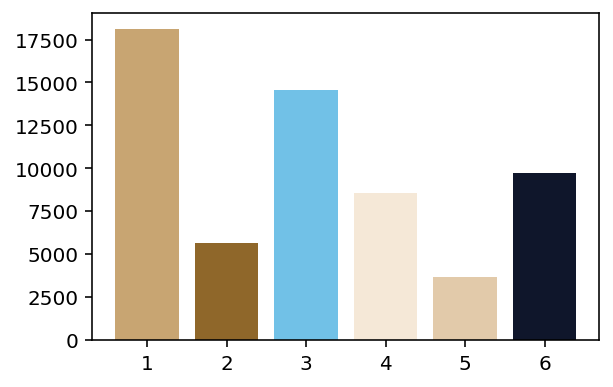

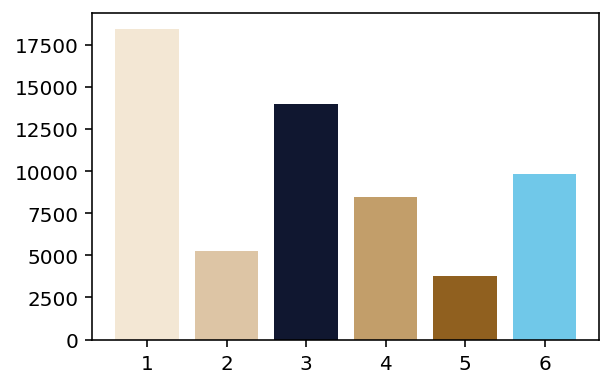

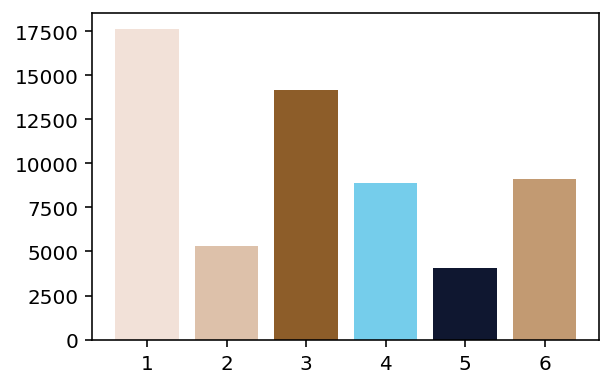

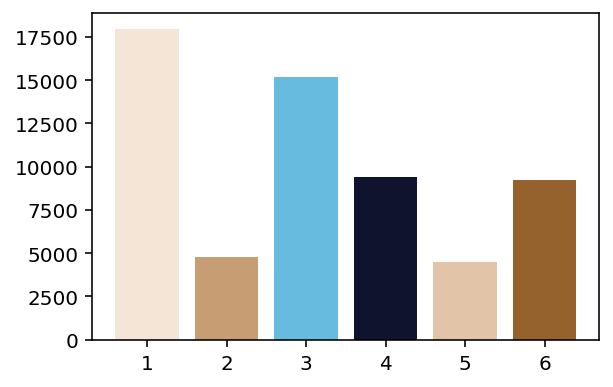

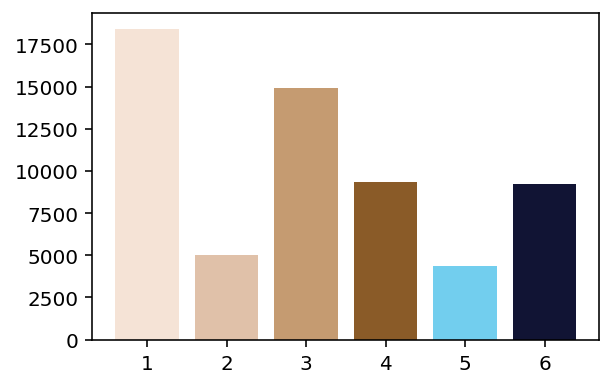

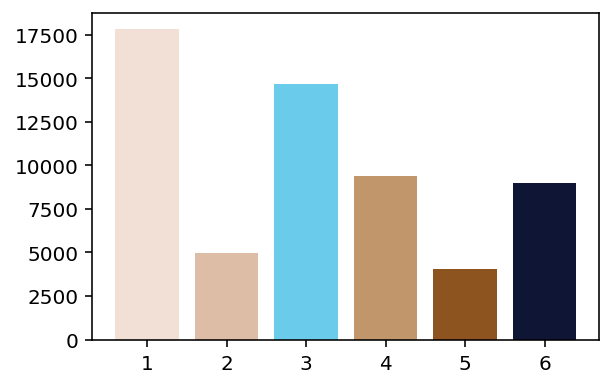

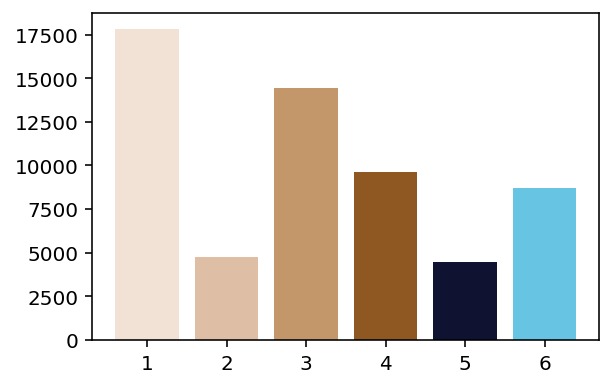

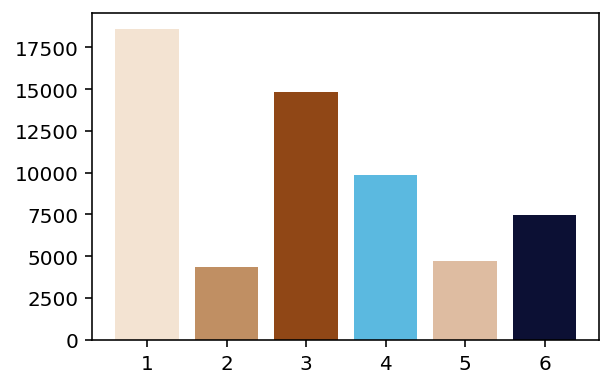

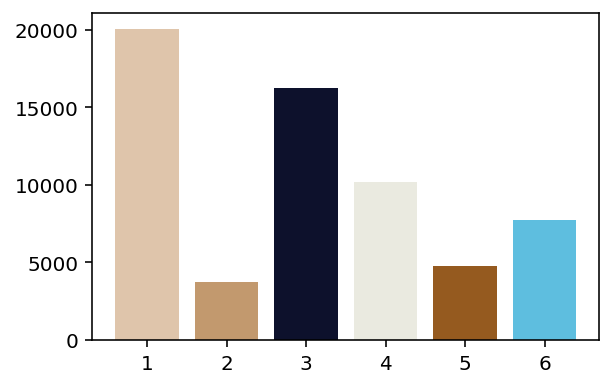

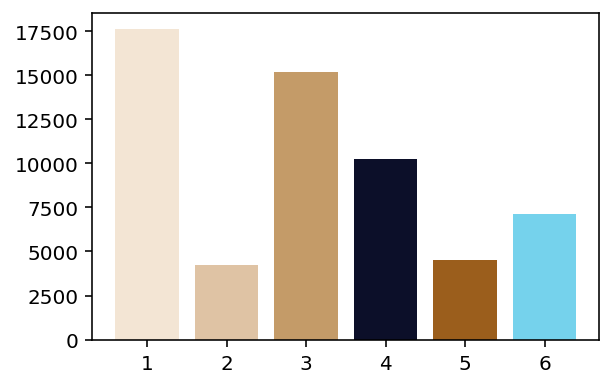

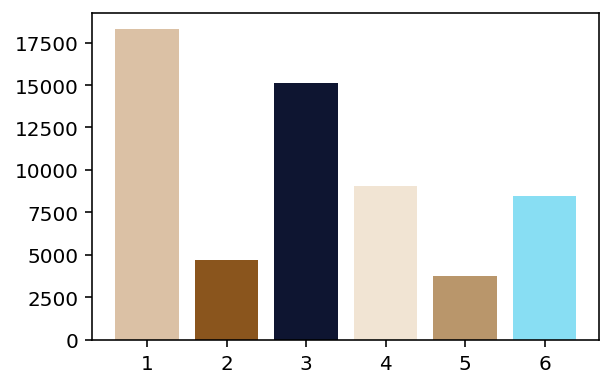

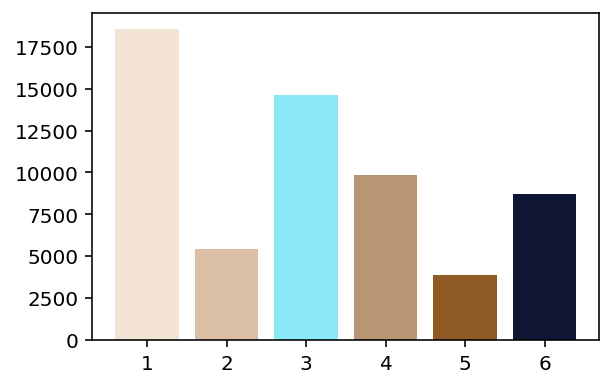

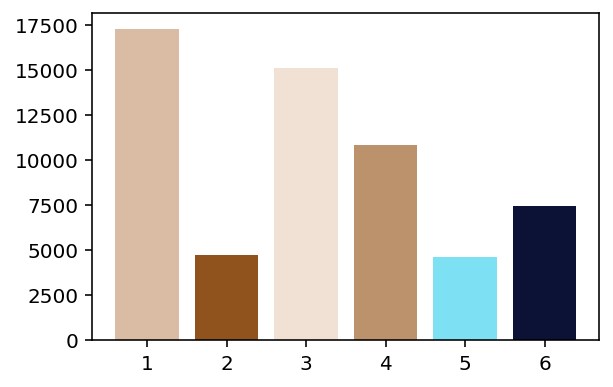

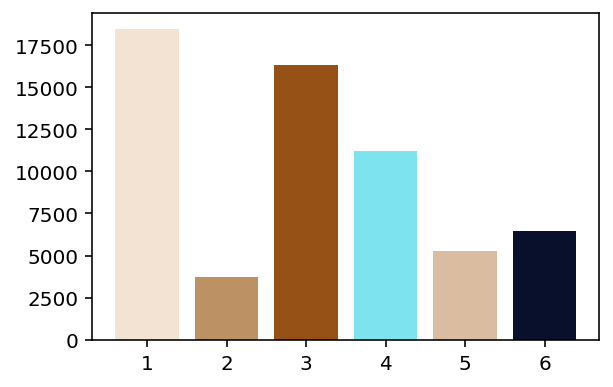

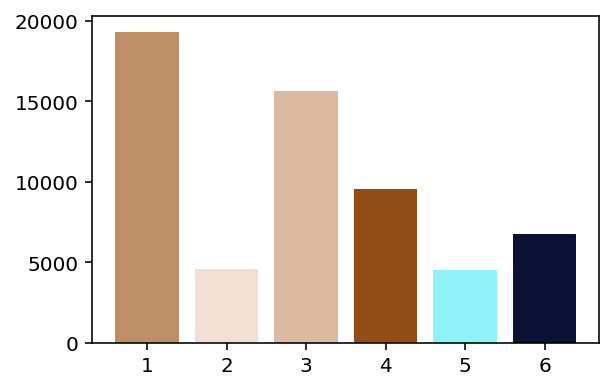

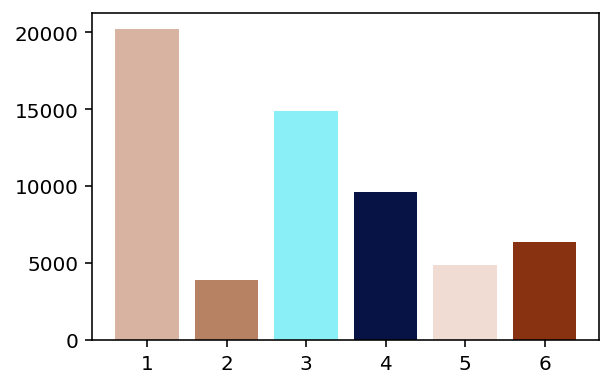

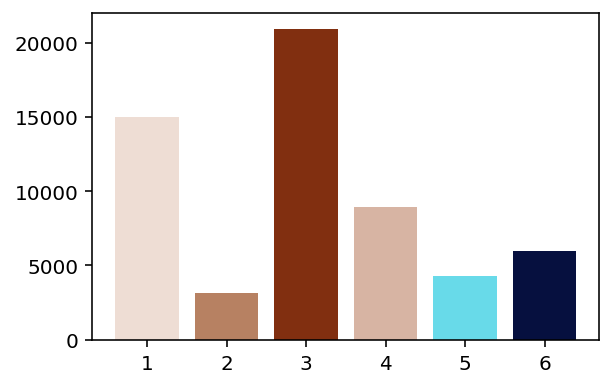

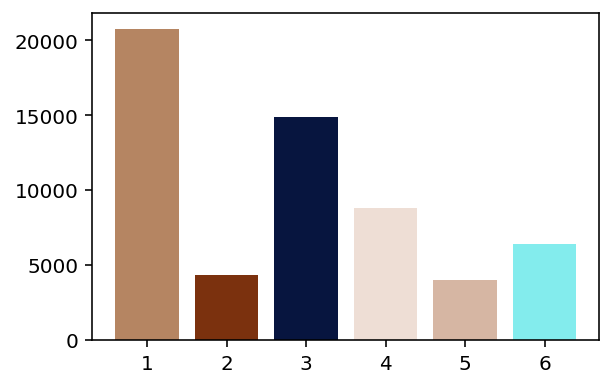

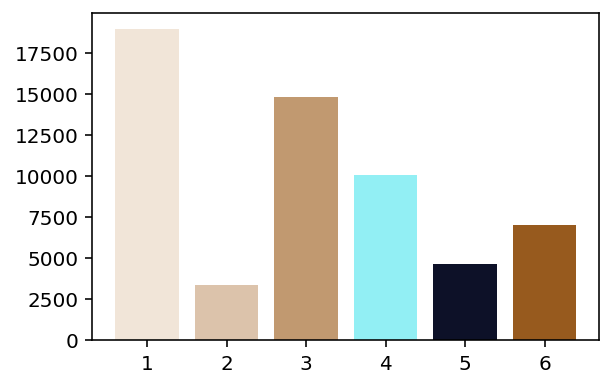

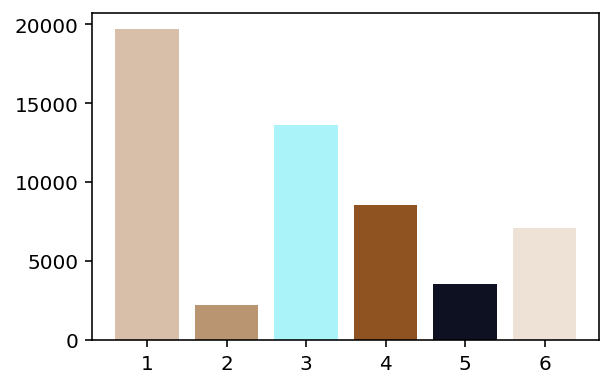

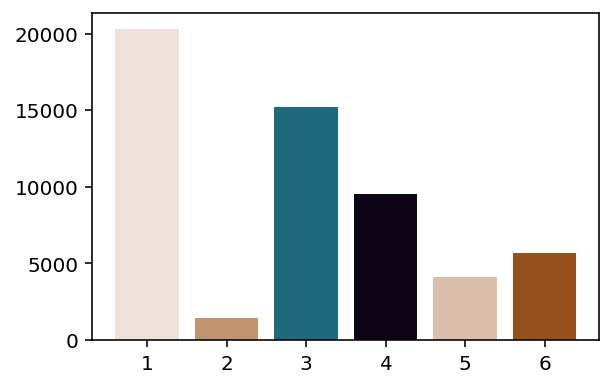

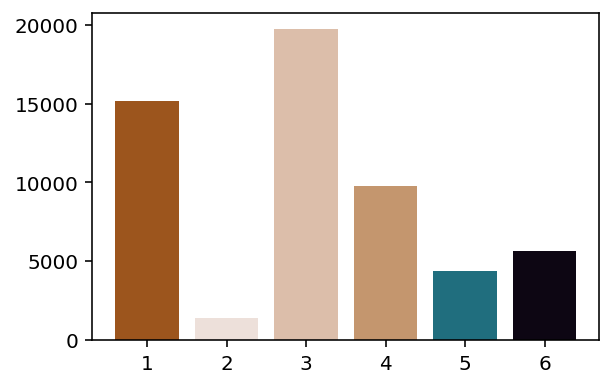

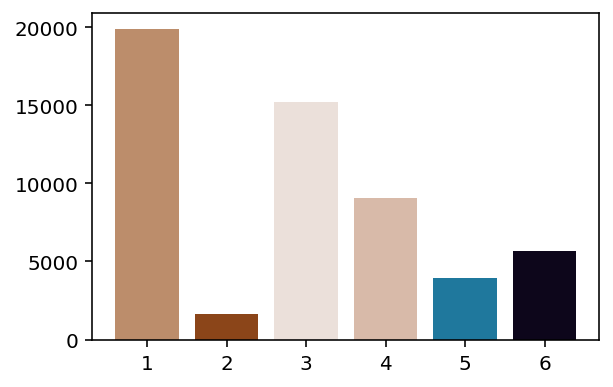

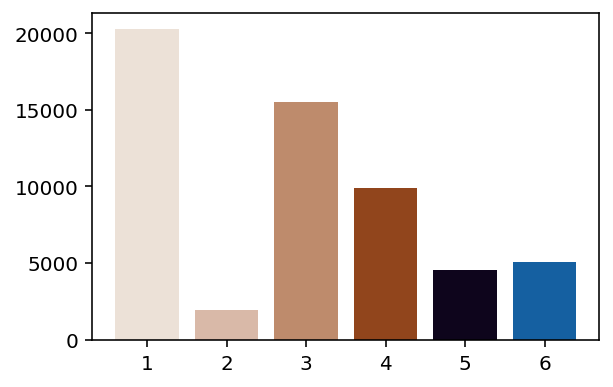

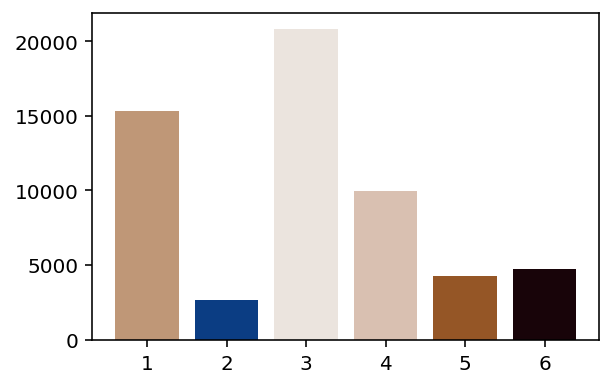

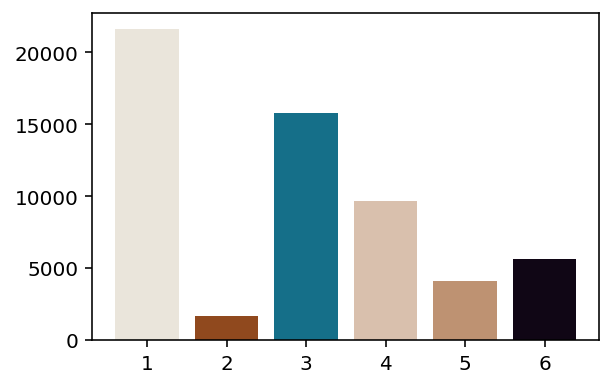

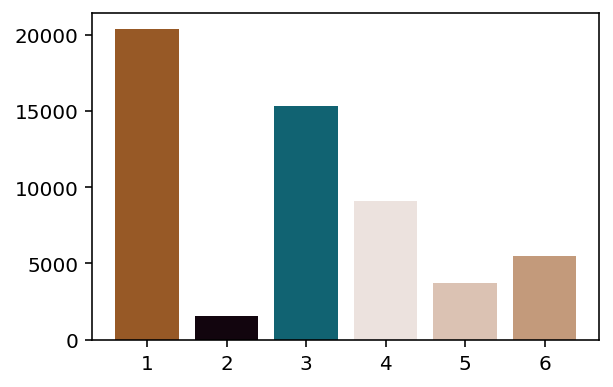

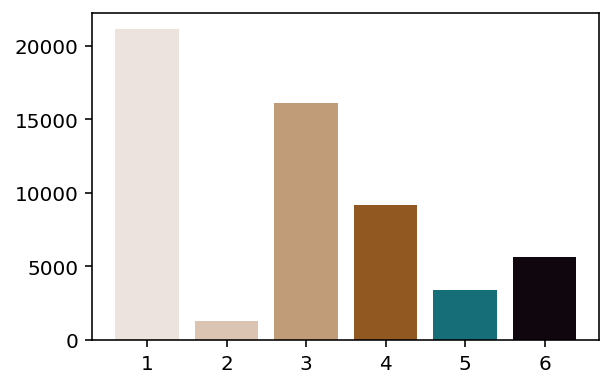

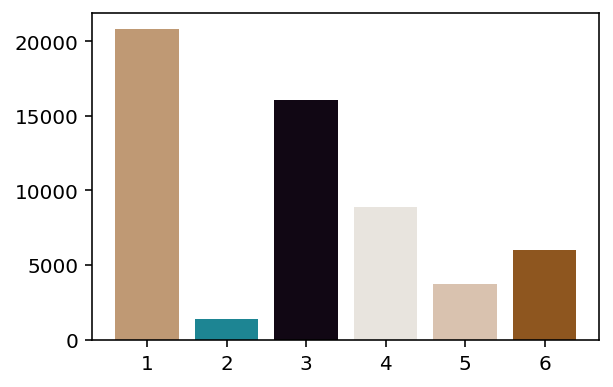

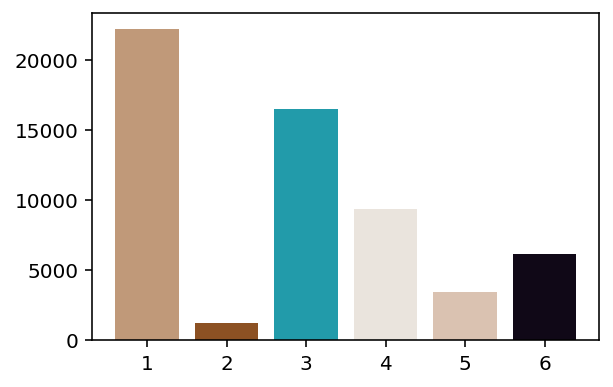

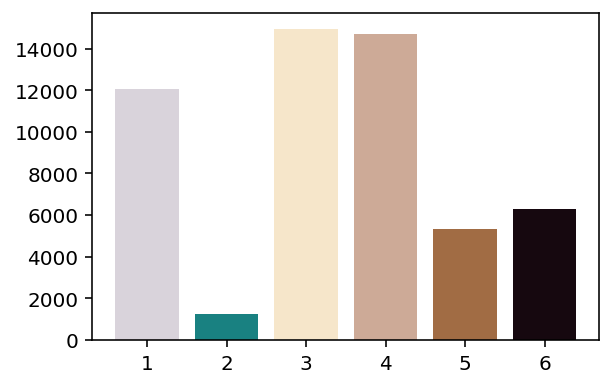

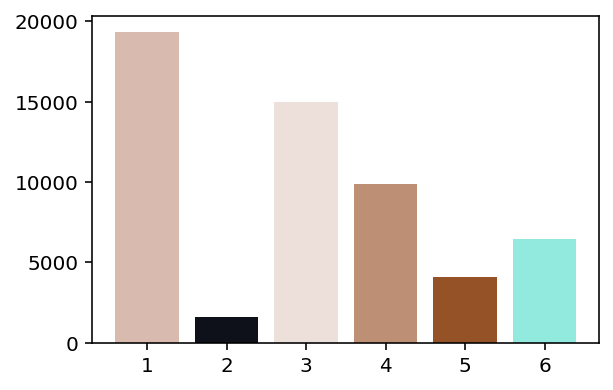

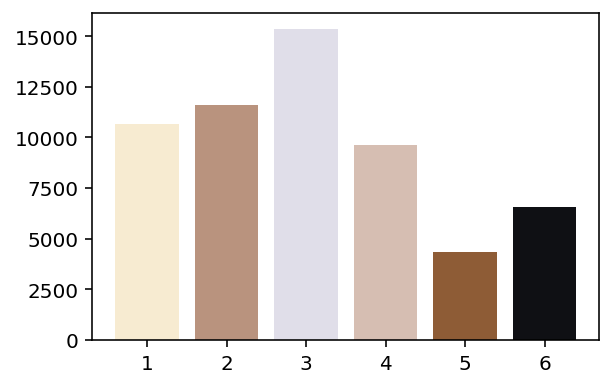

In [497]:
generate_bar_plots(years)

Unfortunately I had to go through each bar chart and manually note which bin my quantize function assigned the blue colors to. I then summed the total pixels representing shades of blue and graphed them against time for each image

In [498]:
indices_arr = [ [3, 6], [3,6], [4,5], [3, 4], [5, 6], [3, 6], [5, 6], [4, 6], [3, 6], [4, 6], [3, 6], [3, 6], [5, 6], [4, 6], [5, 6], [3, 4], [5, 6], [3, 6], [4, 5], [3, 5], [3, 4], [5, 6], [5, 6], [5, 6], [5, 6], [2, 6], [3, 6], [2,3], [5, 6], [2, 3], [3, 6], [2, 6], [2, 6]]



In [499]:
count = 0
total_arr = []
for indicearr in indices_arr:
    total = 0
    for index in indicearr:
        total += colors_arr[count][index - 1][0]
        
    total_arr.append(total)
    count += 1

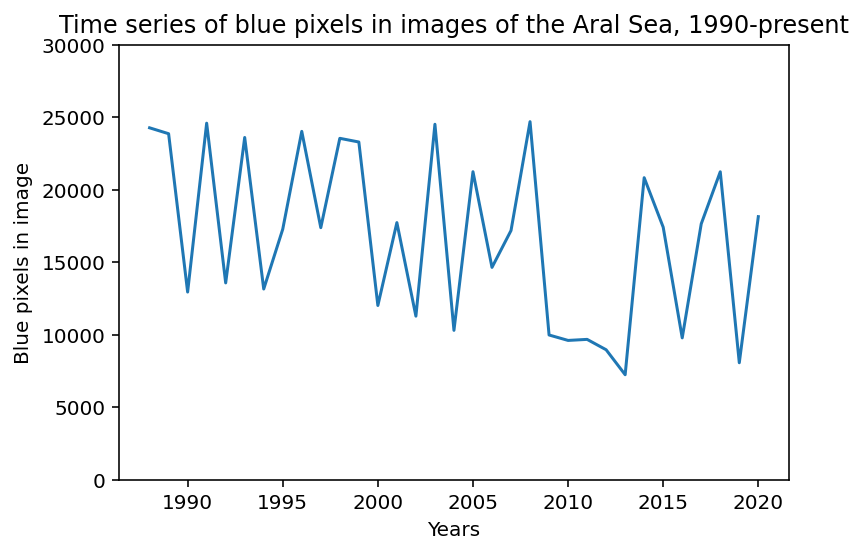

In [500]:
plt.plot(years, total_arr)
plt.xlabel("Years")
plt.ylabel("Blue pixels in image")
plt.title("Time series of blue pixels in images of the Aral Sea, 1990-present")
plt.ylim([0, 30000])
plt.show()

That's not great - the variation between quantity of blue in the images is tremendous! I tried investigating ways this might be occurring. I thought it might be images taken in different months not accounting for the effects of seasonal/monthly changes to the basin like monsoon seasons or snowmelt, but all the images were taken in December of their respective years, so the impact of that should be minimized. Another possible explanation is that our color-replacement technique preserved more of the variation in the blue shades of color than it did for the colors representing the surrounding terrain around the Aral Sea, so the color quantize operation discarded more shades of blue.

Despite these weaknesses there is an encouraging downward trend in the line graph: I want to now see whether this trend matches what we see when looking at the actual data collected from the Aral Sea, and use statistics techniques to evaluate the quality of image processing-based modeling for this particular issue. First let's make a trendline for our existing data to show the negative trend and correlation

R-squared: -0.39033294782214123


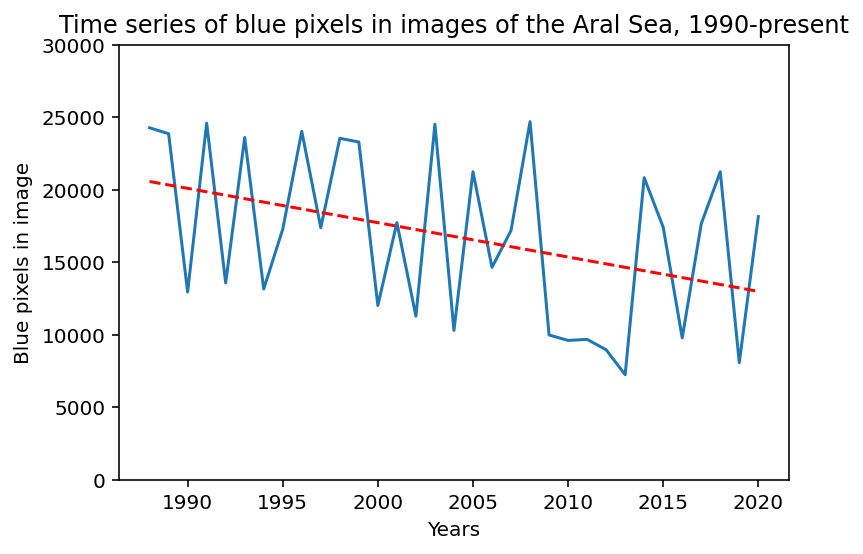

In [340]:
plt.plot(years, total_arr)
plt.xlabel("Years")
plt.ylabel("Blue pixels in image")
plt.title("Time series of blue pixels in images of the Aral Sea, 1990-present")
plt.ylim([0, 30000])

z = np.polyfit(years, total_arr, 1)
p = np.poly1d(z)
plt.plot(years, p(years), "r--")

print("R-squared: " + str(scipy.stats.linregress(years, total_arr)[2]))

plt.show()

That R-squared value is not particularly high but does show some level of correlation between the estimated water level from the image and time, over which we know the Aral Sea shrank considerably. Let's see how this matches up with the actual data for water levels in the Aral that we have access to.

Source: https://www.researchgate.net/figure/Hydrological-observation-data-of-the-Aral-Sea-1957-2009_tbl1_257799140

In [343]:
real_water = pd.read_csv("AralSeaWaterContent.csv")
real_water


,Year,Water Volume (kilometres cubed)
0,1987,345.6
1,1989,327.2
2,1992,260.5
3,1995,239.0
4,1996,217.4
5,1998,195.4
6,2001,149.1
7,2002,129.2
8,2003,117.0
9,2004,115.9


Let's plot this for visual clarity:

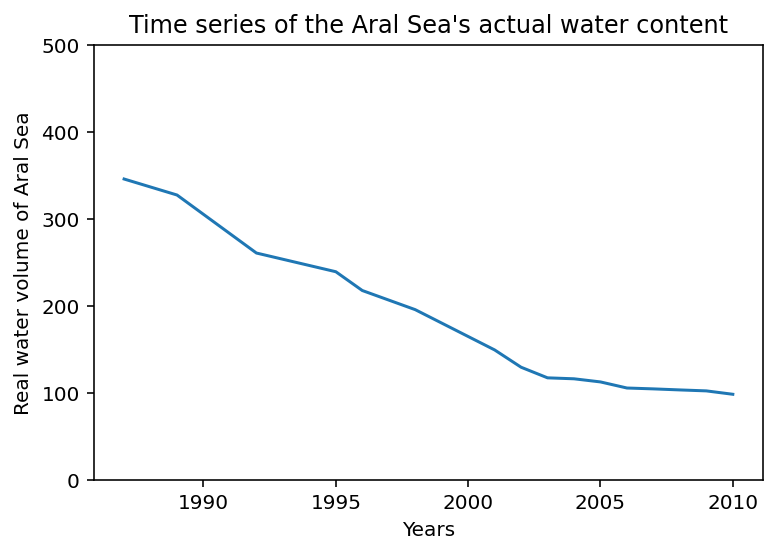

In [349]:
plt.plot(real_water["Year"], real_water["Water Volume (kilometres cubed)"])

plt.xlabel("Years")
plt.ylabel("Real water volume of Aral Sea")
plt.title("Time series of the Aral Sea's actual water content")
plt.ylim([0, 500])

plt.show()


This *seems* like a much more dramatic of a change from start to finish than with our approach (though we should keep in mind that the years the data is collected for are different between the time series and the entire scaling of the y-axes are different. One data transformation we could use to more accurately compare the two would be treating the first year of observation as a base year then doing statistical comparisons based on the difference of each datapoint from said base year

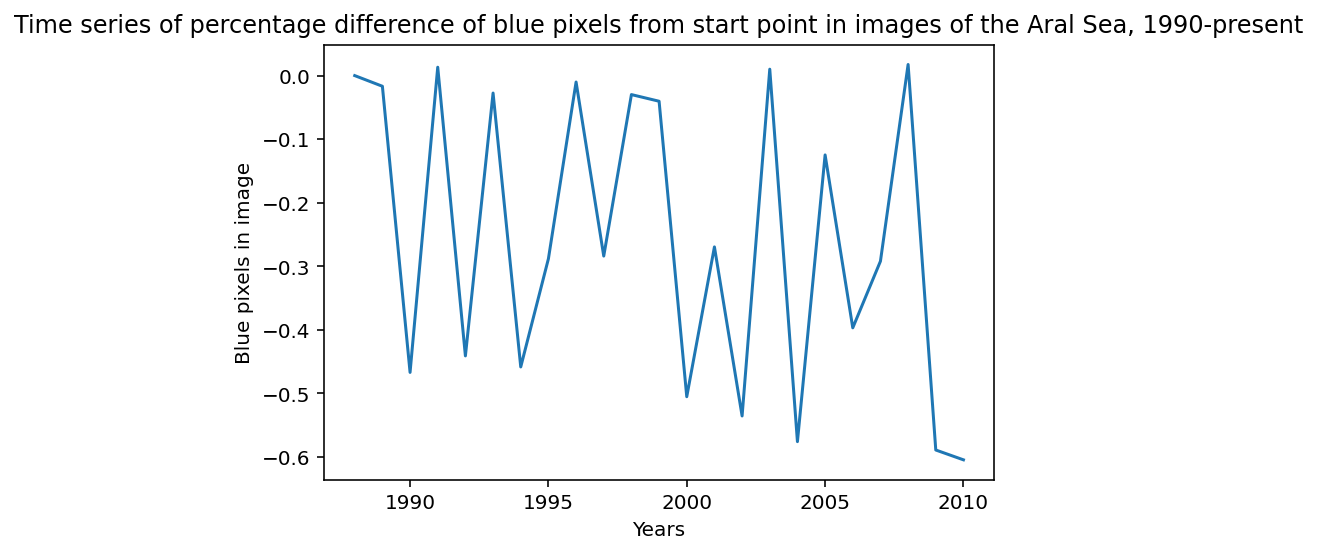

In [383]:
indices_arr2 = [[3, 6], [3,6], [4,5], [3, 4], [5, 6], [3, 6], [5, 6], [4, 6], [3, 6], [4, 6], [3, 6], [3, 6], [5, 6], [4, 6], [5, 6], [3, 4], [5, 6], [3, 6], [4, 5], [3, 5], [3, 4], [5, 6], [5, 6], [5, 6], [5, 6], [2, 6], [3, 6], [2,3], [5, 6], [2, 3], [3, 6], [2, 6], [2, 6]]
years2 = years[0:23]

count2 = 0
total_arr2 = []
for indicearr in indices_arr2:
    total = 0
    for index in indicearr:
        total += colors_arr[count2][index - 1][0]
        
    total_arr2.append((total - total_arr[0])/total_arr[0])
    count2 += 1
    
#total_arr2

plt.plot(years2, total_arr2[0:23])
plt.xlabel("Years")
plt.ylabel("Blue pixels in image")
plt.title("Time series of percentage difference of blue pixels from start point in images of the Aral Sea, 1990-present")
#plt.ylim([0, 30000])

plt.show()


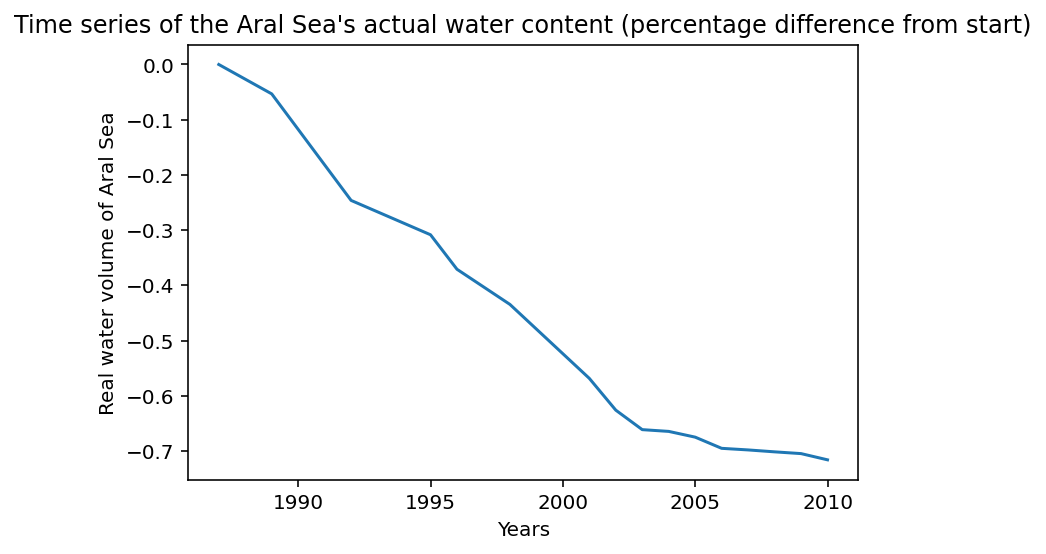

In [372]:
real_water_rescaled = real_water.copy()

real_water_rescaled["Water Volume (kilometres cubed)"] = (real_water["Water Volume (kilometres cubed)"] - real_water["Water Volume (kilometres cubed)"][0])/real_water["Water Volume (kilometres cubed)"][0]

real_water_rescaled

plt.plot(real_water_rescaled["Year"], real_water_rescaled["Water Volume (kilometres cubed)"])

plt.xlabel("Years")
plt.ylabel("Real water volume of Aral Sea")
plt.title("Time series of the Aral Sea's actual water content (percentage difference from start)")
#plt.ylim([0, 500])

plt.show()


This is a encouraging: we see that when we set the start and end years to be the same for both models and normalize them by putting the y-axis in terms of percentage difference from the base year, the start and end points are actually pretty similar: each metric shows a 70% drop in their own estimations of water content within the Aral Sea

In [421]:
#sklearn linear regression model on the image data, see how well it does on the actual data! Since our dataset is so small

img_data_as_df = pd.DataFrame({ "Year":years2 , "Pixel Data": total_arr2[0:23]  })

img_data_as_df

,Year,Pixel Data
0,1988,0.000000
1,1989,-0.016771
2,1990,-0.466870
3,1991,0.013186
4,1992,-0.440910
5,1993,-0.027444
6,1994,-0.458258
7,1995,-0.288116
8,1996,-0.010096
9,1997,-0.283872


In [422]:
img_data_as_df.iloc[[1, 4, 7, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]]

real_water_rescaled.iloc[1:]

,Year,Water Volume (kilometres cubed)
1,1989,-0.053241
2,1992,-0.246238
3,1995,-0.308449
4,1996,-0.370949
5,1998,-0.434606
6,2001,-0.568576
7,2002,-0.626157
8,2003,-0.661458
9,2004,-0.664641
10,2005,-0.675058


In [480]:
merged = pd.merge(img_data_as_df, real_water_rescaled, on = "Year")
merged


,Year,Pixel Data,Water Volume (kilometres cubed)
0,1989,-0.016771,-0.053241
1,1992,-0.440910,-0.246238
2,1995,-0.288116,-0.308449
3,1996,-0.010096,-0.370949
4,1998,-0.029875,-0.434606
5,2001,-0.269449,-0.568576
6,2002,-0.535396,-0.626157
7,2003,0.010096,-0.661458
8,2004,-0.575779,-0.664641
9,2005,-0.124773,-0.675058


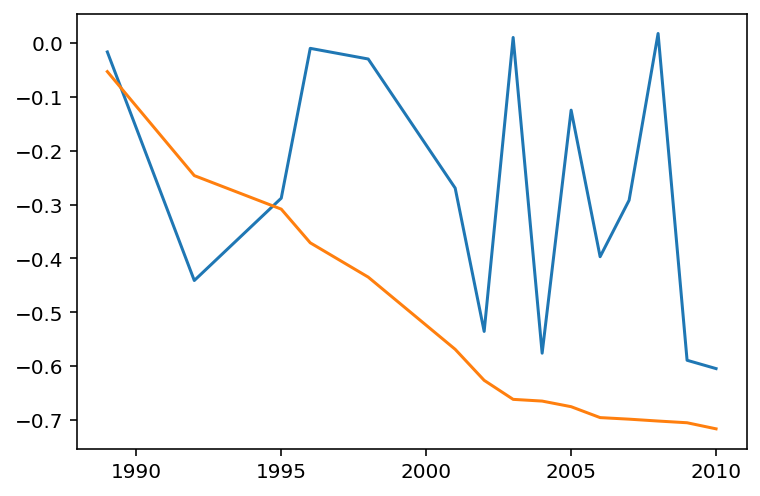

In [430]:
plt.plot(merged["Year"], merged["Pixel Data"])
plt.plot(merged["Year"], merged["Water Volume (kilometres cubed)"])

In [477]:
#train model that predicts the real water volume based on the pixel data
from sklearn.model_selection import train_test_split
import sklearn.linear_model as lm


X = merged.drop(["Water Volume (kilometres cubed)", "Year"], axis = 1)
Y = merged["Water Volume (kilometres cubed)"]

X_train, X_holdout, Y_train, Y_holdout = train_test_split(X, Y, test_size = 0.25)

linear_model = lm.LinearRegression() #one instance of a linreg model

# Fit your linear model
linear_model.fit(X_train, Y_train) #need x and y values as arguments

# Predict housing prices on the test set
Y_pred = linear_model.predict(X_holdout)



In [478]:
merged_with_pred = merged.copy()

merged_with_pred["Predictions"] = linear_model.predict(X)

merged_with_pred

,Year,Pixel Data,Water Volume (kilometres cubed),Predictions
0,1989,-0.016771,-0.053241,-0.448619
1,1992,-0.440910,-0.246238,-0.608234
2,1995,-0.288116,-0.308449,-0.550734
3,1996,-0.010096,-0.370949,-0.446107
4,1998,-0.029875,-0.434606,-0.453550
5,2001,-0.269449,-0.568576,-0.543709
6,2002,-0.535396,-0.626157,-0.643792
7,2003,0.010096,-0.661458,-0.438508
8,2004,-0.575779,-0.664641,-0.658989
9,2005,-0.124773,-0.675058,-0.489263


In [479]:
def rmse(actual_y, predicted_y):
    """
    Args:
        predicted_y: an array of the prediction from the model
        actual_y: an array of the groudtruth label
        
    Returns:
        The root mean square error between the prediction and the groudtruth
    """
    return np.sqrt(np.mean((actual_y - predicted_y)**2))

train_error = rmse(Y_train, linear_model.predict(X_train))
holdout_error = rmse(Y_holdout, linear_model.predict(X_holdout))

print("Training RMSE:", train_error)
print("Validation RMSE:", holdout_error)

Training RMSE: 0.19270955849798874
Validation RMSE: 0.18397588868812847


Our linear model is able to predict, with an ~18% error, the change in water volume of a body of water, when starting from a point with known volume using only topographical data from Google Earth. Though there are obvious limitations to this method, like needing to have the initial volume of the body of water used. Still, this was an interesting exercise and I hope to generalize this model for further use.

Overall this has been a good exercise in data transformation and cleaning primarily, both in relation to image processing in Python.